In [79]:
import os
import cv2
import pathlib
from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
from skimage.util._montage import montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, height, width):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape([width,height]).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list, height, width, all_masks=None):
    # Take the individual ship masks and create a single mask array for all ships
    if all_masks is None:
        all_masks = np.zeros([height, width], dtype = np.uint8)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask, height, width)
    return np.expand_dims(all_masks, -1)

In [12]:
ROOT_DIR = pathlib.Path().absolute()
DATASET_DIR = os.path.join(ROOT_DIR, 'data-science-bowl-2018')
split = 'stage1_train'
path_to_data = os.path.join(DATASET_DIR, split)

In [7]:
masks = pd.read_csv(os.path.join(DATASET_DIR, 'stage1_train_labels.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

29461 masks found
670


,ImageId,EncodedPixels
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,6908 1 7161 8 7417 8 7672 9 7928 9 8184 9 8440...
1,00071198d059ba7f5914a526d124d28e6d010c92466da2...,36269 7 36523 11 36778 13 37033 15 37288 17 37...
2,00071198d059ba7f5914a526d124d28e6d010c92466da2...,19919 6 20174 8 20429 10 20685 11 20941 12 211...
3,00071198d059ba7f5914a526d124d28e6d010c92466da2...,18671 6 18926 8 19181 9 19436 10 19691 11 1994...
4,00071198d059ba7f5914a526d124d28e6d010c92466da2...,40158 3 40413 5 40669 5 40925 5 41182 3


In [9]:
images_with_cell = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_cell = np.unique(images_with_cell.values)
print('There are ' +str(len(images_with_cell)) + ' image files with masks')

There are 670 image files with masks


Image 00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552


AttributeError: 'numpy.ndarray' object has no attribute 'to_list'

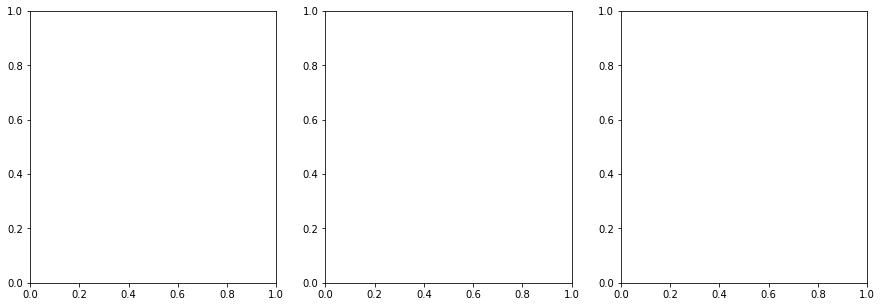

In [139]:
for i in range(1):
    image = images_with_cell[i]
    image_path = os.path.join(path_to_data, image,'images',image + '.png')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5))
    img_0 = cv2.imread(image_path)
    height, width, channels = img_0.shape
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0, height, width)
    #
    # 
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    img_1 = img_0.copy()
    print ('Image', image)
    for prop in props:
        indices = [0, 1, 3, 4]
        bbox = np.take(prop.bbox, indices)
        #(min_row-y, min_col-x, 0, max_row-y, max_col-x, 1)
        #print('Found bbox', prop.bbox)
        cv2.rectangle(img_1, (bbox[1], bbox[0]), (bbox[3], bbox[2]), (255, 0, 0), 2)


    ax1.imshow(img_0)
    ax1.set_title('Image')
    ax2.set_title('Mask')
    ax3.set_title('Image with derived bounding box')
    ax2.imshow(mask_0[...,0], cmap='gray')
    ax3.imshow(img_1)
    plt.show()
    #(min_row, min_col, 0, max_row, max_col, 1)

In [148]:
import gc 
bboxes_dict = {}
i = 0
for image in tqdm(images_with_cell):
    image_path = os.path.join(path_to_data, image,'images',image + '.png')
    img_0 = cv2.imread(image_path)
    height, width, channels = img_0.shape
    # make better mask props
    rle_0 = masks.query('ImageId=="'+image+'"')['EncodedPixels']
    mask_0 = masks_as_image(rle_0, height, width)
    lbl_0 = label(mask_0) 
    props = regionprops(lbl_0)
    bboxes = []
    for prop in props:
        indices = [0, 1, 3, 4]
        bbox = np.take(prop.bbox, indices).tolist()
        bboxes.append(bbox)
        
        
    i = i + 1
    if i % 500 == 0:
        gc.collect()
        
    bboxes_dict[image] = bboxes


100%|██████████| 670/670 [00:24<00:00, 27.43it/s]


In [153]:
bboxes_df = pd.DataFrame([bboxes_dict])
bboxes_df = bboxes_df.transpose()
bboxes_df.columns = ['bbox_list']
bboxes_df.head()

,bbox_list
00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552,"[[8, 0, 18, 5], [24, 0, 25, 1], [247, 26, 256,..."
003cee89357d9fe13516167fd67b609a164651b21934585648c740d2c3d86dc1,"[[164, 0, 176, 10], [130, 14, 141, 29], [166, ..."
00ae65c1c6631ae6f2be1a449902976e6eb8483bf6b0740d00530220832c6d3e,"[[0, 0, 6, 12], [136, 0, 162, 11], [233, 0, 25..."
0121d6759c5adb290c8e828fc882f37dfaf3663ec885c663859948c154a443ed,"[[46, 0, 66, 10], [101, 0, 138, 12], [172, 0, ..."
01d44a26f6680c42ba94c9bc6339228579a95d0e2695b149b7cc0c9592b21baf,"[[95, 0, 128, 41], [179, 20, 232, 46], [234, 5..."


In [154]:
bboxes_df.to_csv('bbox_dictionary.csv')

In [122]:
data = pd.read_csv('bbox_dictionary.csv')

In [123]:
data.head(1)

,Unnamed: 0,bbox_list
0,00071198d059ba7f5914a526d124d28e6d010c92466da2...,"[[8, 0, 18, 5], [24, 0, 25, 1], [247, 26, 256,..."
